In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 40
nA = 2
seed = get_current_seed()
#seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 273380649406692091924101768071309104151


In [2]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.08, alpha_pol = 0.03, episodes=1500000, 
                        batch_nS=12, temperature=5., biased=False, lam=0, 
                        epochs=1, use_delta_Q=False, final_temperature=1)


No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 1382 length: 12 #teleports:1370
Time for bound evaluation:  0.13465261459350586
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 3127 length: 12 #teleports:1733
Time for bound evaluation:  0.003000974655151367
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 4601 length: 12 #teleports:1462
Time for bound evaluation:  0.003000497817993164
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 5800 length: 12 #teleports:1187
Time for bound evaluation:  0.003000497817993164
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 6780 length: 12 #teleports:968
Time for bound evaluation:  0.004000663757324219
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 7634 length: 12 #teleports:842
Time for bound evaluation:  0.007002353668212891
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 8421 length: 12 #teleports:775
Time for bound ev

In [3]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["thetas"][-1]))

[[1.00000000e+00 8.14253447e-22]
 [1.00000000e+00 1.93061512e-19]
 [1.00000000e+00 9.34204430e-18]
 [1.00000000e+00 6.34701428e-16]
 [1.00000000e+00 2.38733966e-14]
 [1.00000000e+00 1.04845612e-12]
 [1.00000000e+00 2.88499925e-11]
 [9.99999999e-01 6.39395531e-10]
 [9.99999983e-01 1.72920408e-08]
 [9.99999710e-01 2.89575527e-07]
 [9.99995547e-01 4.45274468e-06]
 [9.99968266e-01 3.17340755e-05]
 [9.99759779e-01 2.40221293e-04]
 [9.98682969e-01 1.31703139e-03]
 [9.94812496e-01 5.18750377e-03]
 [9.83279122e-01 1.67208783e-02]
 [9.58357410e-01 4.16425900e-02]
 [9.17890958e-01 8.21090415e-02]
 [8.62691055e-01 1.37308945e-01]
 [7.97902390e-01 2.02097610e-01]
 [7.38865185e-01 2.61134815e-01]
 [6.88834205e-01 3.11165795e-01]
 [6.43575821e-01 3.56424179e-01]
 [6.03649410e-01 3.96350590e-01]
 [5.77364512e-01 4.22635488e-01]
 [5.57425750e-01 4.42574250e-01]
 [5.41841635e-01 4.58158365e-01]
 [5.28255266e-01 4.71744734e-01]
 [5.17092950e-01 4.82907050e-01]
 [4.97760583e-01 5.02239417e-01]
 [4.473539

In [4]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]
print(Q)
d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_softmax_policy(cur_res["thetas"][-1]), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(cur_res["thetas"][-1]))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

[[ 49.99999551  43.64999596]
 [ 44.99999596  39.73499632]
 [ 40.49999636  35.76149669]
 [ 36.44999673  32.18534702]
 [ 32.80499705  28.96681232]
 [ 29.52449735  26.07013109]
 [ 26.57204761  23.46311798]
 [ 23.91484285  21.11680618]
 [ 21.52335857  19.00512556]
 [ 19.37102271  17.10461301]
 [ 17.43392044  15.39415171]
 [ 15.6905284   13.85473653]
 [ 14.12147556  12.46926288]
 [ 12.709328    11.22233659]
 [ 11.4383952   10.10010293]
 [ 10.29455568   9.09009264]
 [  9.26510011   8.18108338]
 [  8.3385901    7.36297504]
 [  7.50473109   6.62667753]
 [  6.75425798   5.96400978]
 [  6.07883218   5.3676088 ]
 [  5.47094897   4.83084792]
 [  4.92385407   4.34776313]
 [  4.43146866   3.91298682]
 [  3.9883218    3.74533649]
 [  3.58948962   4.41781698]
 [  3.97603529   6.19721111]
 [  5.57749      9.08560646]
 [  8.17704581  13.41344493]
 [ 12.07210043  19.82400086]
 [ 17.84160077  29.30307587]
 [ 26.37276829  43.31575907]
 [ 38.98418316  64.02952761]
 [ 57.62657485  94.64875737]
 [ 85.18388163

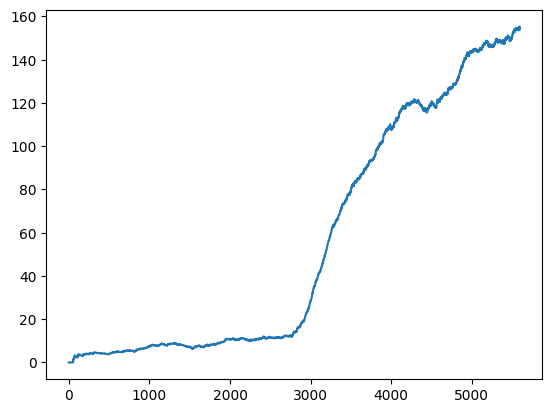

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list)/12)
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)